In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint

train_1 = np.array(pd.read_csv('Part2_1_Train.csv', header=None))
train_3 = np.array(pd.read_csv('Part2_3_Train.csv', header=None))
test_1 = np.array(pd.read_csv('Part2_1_Test.csv', header=None))
test_3 = np.array(pd.read_csv('Part2_3_Test.csv', header=None))

np.random.seed(21)
X_train = np.vstack((train_1, train_3))
y_train = np.concatenate((np.tile(0, train_1.shape[0]), np.tile(1, train_3.shape[0])))
idx_train = np.array(range(X_train.shape[0]))
np.random.shuffle(idx_train)
X_train = X_train[idx_train]
y_train = y_train[idx_train]

X_test = np.vstack((test_1, test_3))
y_test = np.concatenate((np.tile(0, test_1.shape[0]), np.tile(1, test_3.shape[0])))
idx_test = np.array(range(X_test.shape[0]))
np.random.shuffle(idx_test)
X_test = X_test[idx_test]
y_test = y_test[idx_test]

enc = np.eye(2)
def one_hot(d):
    return enc[d]

print(train_1.shape, train_3.shape, test_1.shape, test_3.shape)
print(X_train.shape, X_test.shape)

(17, 784) (17, 784) (50, 784) (50, 784)
(34, 784) (100, 784)


In [2]:
W_conv = np.empty((2, 28*28+1))
W_out = np.empty((2, 2+1))

class seeded_session:
    def __enter__(self):
        np.random.seed(25523)
        global W_conv, W_out
        W_conv[:] = np.random.rand(2, 28*28+1)*1e-5
        W_out[:] = np.random.rand(2, 2+1)
        return W_conv, W_out
    def __exit__(self, type, value, traceback):
        pass

with seeded_session():
    print(W_conv.shape, W_out.shape)

(2, 785) (2, 3)


# Forward pass

[ 0.57186129  0.42813871] 0
[ 0.57183252  0.42816748] 1


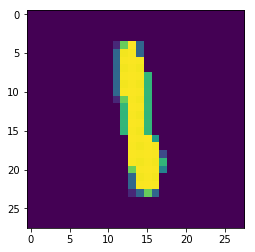

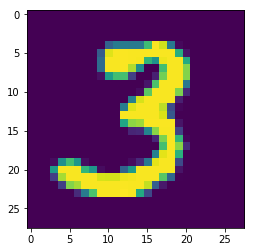

In [3]:
def conv(w, n):
#     nW = w.shape[0] - 1 # number of weights (excluding bias) in the layer
#     forward = lambda s: np.tanh(np.dot(w, np.append(s, 1.0)))
#     return lambda x: np.array([forward(x[i: i+nW]) for i in range(n)])
    # since there isn't any real convolution happening...
    return lambda x: np.array([np.tanh(np.dot(w, np.append(x, 1.0)))])

def softmax(x):
    a = np.exp(x)
    return a / np.sum(a)

def perceptron(w):
    return lambda x: np.dot(w, np.append(x, 1.0))

conv_filters = [conv(w, 1) for w in W_conv]
conv_layer = lambda x: np.array([f(x) for f in conv_filters])
output_neurons = [perceptron(w) for w in W_out]
fc_layer = lambda x: softmax([f(x) for f in output_neurons])
model = lambda x: fc_layer(conv_layer(x))

with seeded_session():
    for k in range(2):
        plt.figure()
        plt.imshow(X_train[k].reshape(28, 28).T)
        print(model(X_train[k]), y_train[k])

# Backward pass

Assuming loss function: $ \text{loss}(\mathbf{y}) = -\sum_j { d_j \log y_j } $

**Output layer**

$$
\delta_j^H = \frac{\partial E}{\partial \nu_j^H} = -e_j
$$

$$
\Delta w_{ij}^H = -\alpha \delta_j^H y_i^{H-1}
$$

$$
\Delta b_j^H = -\alpha \delta_j^H
$$

**Hidden layer**

$$
\delta_j^h = \frac{\partial E}{\partial \nu_j^h} = \left( \sum_{l = 1}^{L^{h+1}} \frac{\partial E}{\partial \nu_l^{h+1}} \frac{\partial \nu_l^{h+1}}{\partial y_j^h} \right) \frac{\partial y_j^h}{\partial \nu_j^h}
=\left( \sum_{l = 1}^{L^{h+1}} {\delta_l^H w_{jl}^H} \right) (1-(y_j^h)^2)
$$

$$
\Delta w_{i}^h = -\alpha \sum_{j=1}^{L^0} {\delta_j^h \frac{\partial \nu_j^h}{\partial w_i^h}}
=-\alpha \sum_{j=1}^{L^0} {\delta_j^h  {x_{j+i-1}}}
$$

$$
\Delta b^h = -\alpha \sum_{j=1}^{L^0} {\delta_j^h \frac{\partial \nu_j^h}{\partial b^h}}
=-\alpha \sum_{j=1}^{L^0} {\delta_j^h }
$$

In [4]:
def train_one(x, d, alpha):
    y_conv = conv_layer(x) # shape: (filter, spatial) = (2, 1)
    y_output = fc_layer(y_conv) # shape: (neuron, ) = (2, )
    e = one_hot(d) - y_output
    # delta_out.shape == y_output.shape
    delta_out = -e
    # W_out.shape: (neuron: j, [out] weights+bias: i) = (2, 2+1)
    update_out = -alpha * np.outer(delta_out, np.append(np.ravel(y_conv), 1.0))
    # delta_conv.shape == y_conv.shape
    #                        vvvv output weights without any bias
    delta_conv = (np.dot(W_out[:, :-1].T, delta_out) * np.ravel(1-y_conv**2)).reshape(y_conv.shape)
    # W_conv.shape: (filter, [conv] weights+bias) = (2, 28*28+1)
    update_conv = np.zeros(W_conv.shape)
    for idx_filter in range(update_conv.shape[0]):
        update_conv[idx_filter, :] = -alpha * np.array(
            [np.dot(delta_conv[idx_filter], x[i: i+delta_conv.shape[1]])
                for i in range(W_conv.shape[1]-1)] +
            [np.sum(delta_conv[idx_filter])]
        )
    return {k:v for k,v in locals().items() if k not in set(['x'])}

with seeded_session():
    pprint(train_one(X_train[0], y_train[0], 0.2))

{'alpha': 0.2,
 'd': 0,
 'delta_conv': array([[ 0.16017613],
       [ 0.00313819]]),
 'delta_out': array([-0.42813871,  0.42813871]),
 'e': array([ 0.42813871, -0.42813871]),
 'idx_filter': 1,
 'update_conv': array([[-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.03203523],
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.00062764]]),
 'update_out': array([[  3.05496481e-05,   3.13843981e-05,   8.56277426e-02],
       [ -3.05496481e-05,  -3.13843981e-05,  -8.56277426e-02]]),
 'y_conv': array([[ 0.00035677],
       [ 0.00036652]]),
 'y_output': array([ 0.57186129,  0.42813871])}


In [5]:
def autograd(params, f):
    epsilon = 1e-6
    backup = params.copy().ravel()
    grad = np.empty(params.shape)
    for i in range(len(backup)):
        params.flat[i] = backup[i] + epsilon
        f1 = f()
        params.flat[i] = backup[i] - epsilon
        f2 = f()
        grad.flat[i] = (f1-f2)/(epsilon*2.0)
        params.flat[i] = backup.flat[i]
    return grad

def train_one_autodiff(x, d, alpha):
    loss = lambda x, d: -np.sum(one_hot(d)*np.log(model(x)))
    update_out = -alpha * autograd(W_out, lambda: loss(x, d))
    update_conv = -alpha * autograd(W_conv, lambda: loss(x, d))
    return {k:v for k,v in locals().items() if k not in set(['x', 'loss'])}

with seeded_session():
    pprint(train_one_autodiff(X_train[0], y_train[0], 0.2))

{'alpha': 0.2,
 'd': 0,
 'update_conv': array([[-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.03203523],
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.00062764]]),
 'update_out': array([[  3.05496628e-05,   3.13843951e-05,   8.56277426e-02],
       [ -3.05496628e-05,  -3.13843951e-05,  -8.56277426e-02]])}


In [6]:
from ipywidgets import IntProgress
from IPython.display import display

loss = []
acc = []
vacc = []
epochs = 25

progress = IntProgress(description='epoch', min=0, max=epochs-1)
display(progress)

with seeded_session():
    for i_epoch in range(epochs):
        epoch_loss = []
        epoch_acc = []
        for x, d in zip(X_train, y_train):
            v = train_one(x, d, 0.001)
            epoch_loss.append(-np.sum(one_hot(d)*np.log(v['y_output'])))
            epoch_acc.append(np.argmax(v['y_output']) == d)
            W_conv += v['update_conv']
            W_out += v['update_out']
        acc.append(np.mean(epoch_acc))
        loss.append(np.mean(epoch_loss))
        epoch_vacc = []
        for x, d in zip(X_test, y_test):
            y = model(x)
            epoch_vacc.append(np.argmax(y) == d)
        vacc.append(np.mean(epoch_vacc))
        progress.value = i_epoch

IntProgress(value=0, description='epoch', max=24)

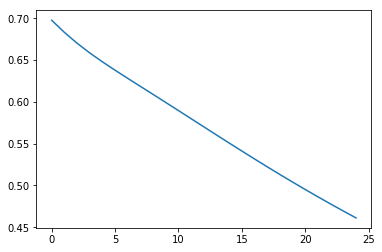

In [7]:
plt.plot(list(range(epochs)), loss)

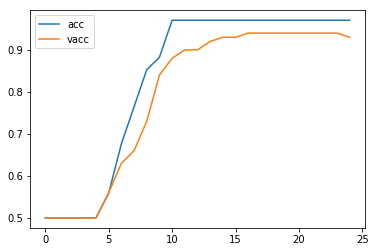

In [8]:
plt.plot(list(range(epochs)), acc, label='acc')
plt.plot(list(range(epochs)), vacc, label='vacc')
plt.legend()

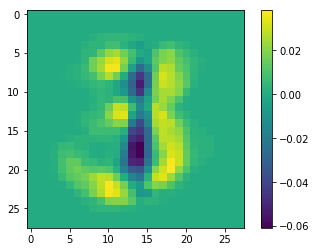

In [9]:
plt.imshow(W_conv[0, :-1].reshape(28, 28).T)
plt.colorbar()

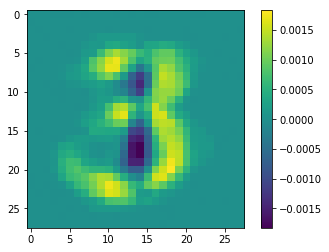

In [10]:
plt.imshow(W_conv[1, :-1].reshape(28, 28).T)
plt.colorbar()